## FDTree Class

In [4]:
import time
import klepto
import shelve
import pickle
import h5py
import numpy as np
from scipy.sparse import *
import matplotlib.pyplot as plt

In [5]:
dataset = '1m'

In [7]:
feature=h5py.File('movielens/' + dataset + '/test_list.mat')  
test_list = feature['test_list'][:]
test_list = list(map(int, test_list.T[0]))
test_list = [i-1 for i in test_list] 
feature=h5py.File('movielens/' + dataset + '/train_list.mat')  
train_list = feature['train_list'][:]
train_list = list(map(int, train_list.T[0]))
train_list = [i-1 for i in train_list] 

In [8]:
rating_matrix_csc = load_npz('movielens/sparse_matrix_ml-' + dataset + '_selected.npz').tocsc()
rating_matrix_csc_train = rating_matrix_csc[:, train_list]
rating_matrix_csc_test  = rating_matrix_csc[:, test_list]
print("file load DONE")
depth_threshold = 8

file load DONE


## Step 1: Input Dataset

In [9]:
class DecisionTreeModel:
    def __init__(self, source, depth_threshold=10, plambda=7, MSP_item=200):
        
        self.sMatrix = source
        self.depth_threshold = depth_threshold
        self.plambda = plambda
        self.MSP_item = MSP_item

        #### Calculate rate of progress ####
        self.cur_depth = 0
        self.node_num = 0
        self.cur_node = 0
        for i in range(self.depth_threshold):
            self.node_num += 3 ** i
        
        #### Initiate Tree, lr_bound ####
        self.tree = list(range(self.sMatrix.shape[1]))
        self.split_item = []
        self.lr_bound = {'0': [[0, len(self.tree) - 1]]}

        #### Generate bias, sum_cur_t, sum_2_cur_t ####
        #### Generate rU ####        
        self.rU = {}        
        for dictname in range(int(self.sMatrix.shape[1]/5000) + 1):
            d = shelve.open('rU_data/'+str(dictname), protocol = pickle.HIGHEST_PROTOCOL)
            self.rU.update(d['content'])
            d.close()
        print("rU DONE")
        
        Tree = klepto.archives.dir_archive('treeFile', {}, serialized=True)
        Tree.load()
        self.biasU       = Tree["biasU"]
        self.sum_cur_t   = Tree["sum_cur_t"]
        self.sum_2_cur_t = Tree["sum_2_cur_t"]
        self.sum_cntt    = Tree["sum_cntt"]
        self.item_size = self.sMatrix.shape[0]
        self.user_size = len(self.tree)        
        self.MPS = []
        print("Initiation DONE!")

    def calculate_error(self, sumt, sumt_2, cntt):
        ''' Calculate error for one item-split in one node '''
        Error_i = np.sum(sumt_2 - (sumt ** 2) / (cntt + 1e-9))

        return Error_i

    def generate_decision_tree(self, lr_bound_for_node, chosen_id):
        #### Terminate ####
        self.cur_depth += 1
        if self.cur_depth > self.depth_threshold or len(chosen_id) == self.item_size:
            return   
        
        #### Choose Most Popular Items of This Node ####     
        num_rec = np.zeros(self.item_size)
        for userid in self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)]:
            user_all_rating_id = np.array(list(self.rU[userid].keys()))
            num_rec[user_all_rating_id] += 1
        MPS_item_id = list(np.argsort(-num_rec)[:])
        for item_id in chosen_id:
            MPS_item_id.remove(item_id)
        MPS_item_id = MPS_item_id[:self.MSP_item]
            
        #### Find optimum item to split ####
        min_sumtL, min_sumtD, min_sumtL_2, min_sumtD_2, min_sumtU, min_sumtU_2, Error = {}, {}, {}, {}, {}, {}, {}
        min_Error = "None"
        for itemid in MPS_item_id:
            if itemid in chosen_id:
                continue
            '''
                user_rating_item_in_nodet: np.array([ [uid01, rating01], [uid02, rating02], ... ])
                to find all users in node t who rates item i
            '''
            
            user_rating_item_in_nodet = np.array([[userid, self.rU[userid][itemid]] for userid in
                                         self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)] if
                                         itemid in self.rU[userid]])         
            sumt = np.zeros((self.item_size, 3))
            sumt_2 = np.zeros((self.item_size, 3))
            cntt = np.zeros((self.item_size, 3))
            for user in user_rating_item_in_nodet:
                ''' user_all_rating: array [ [itemid11, rating11], [itemid12, rating12], ... ] '''
                user_all_rating_id = np.array(list(self.rU[user[0]].keys()))
                user_all_rating = np.array(list(self.rU[user[0]].values()))
                #### calculate sumtL for node LIKE ####
                if user[1] > 3:
#                     split.setdefault(itemid, []).append(user[0])
                    sumt[user_all_rating_id[:], 0] += user_all_rating[:] - self.biasU[user[0]]
                    sumt_2[user_all_rating_id[:], 0] += (user_all_rating[:] - self.biasU[user[0]]) ** 2
                    cntt[user_all_rating_id[:], 0] += 1
                #### calculate sumtD for node DISLIKE ####
                elif user[1] <= 3:
                    sumt[user_all_rating_id[:], 1] += user_all_rating[:] - self.biasU[user[0]]
                    sumt_2[user_all_rating_id[:], 1] += (user_all_rating[:] - self.biasU[user[0]]) ** 2
                    cntt[user_all_rating_id[:], 1] += 1

            #### calculate sumtU for node UNKNOWN ####
            sumt[:, 2] = self.sum_cur_t[:] - sumt[:, 0] - sumt[:, 1]
            sumt_2[:, 2] = self.sum_2_cur_t[:] - sumt_2[:, 0] - sumt_2[:, 1]
            cntt[:, 2] = self.sum_cntt[:] - cntt[:, 0] - cntt[:, 1]
            Error[itemid] = self.calculate_error(sumt, sumt_2, cntt)
            if min_Error == "None" or Error[itemid] < min_Error:
                min_sumt = sumt
                min_sumt_2 = sumt_2
                min_cntt = cntt
                min_Error = Error[itemid]
        #### Find optimum split-item ####
        optimum_itemid = min(Error, key=Error.get)
        if len(self.split_item) == self.cur_depth - 1:
            self.split_item.append([optimum_itemid])
        else:
            self.split_item[self.cur_depth - 1].append(optimum_itemid)
        chosen_id.append(optimum_itemid)
#         print(Error)
        print("split item found!")
#         print(optimum_itemid)
        #### sort tree ####
        self.lr_bound.setdefault(str(self.cur_depth), []).append([])  # for LIKE
        self.lr_bound[str(self.cur_depth)].append([])  # for DISLIKE
        self.lr_bound[str(self.cur_depth)].append([])  # for UNKNOWN
        listU, listL, listD = [], [], []
        for userid in self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)]:
            if optimum_itemid not in self.rU[userid]:
                listU.append(userid)
            elif self.rU[userid][optimum_itemid] >= 4:
                listL.append(userid)
            elif self.rU[userid][optimum_itemid] <= 3:
                listD.append(userid)
        self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)] = listL + listD + listU
        self.lr_bound[str(self.cur_depth)][-3] = [lr_bound_for_node[0],
                                                  lr_bound_for_node[0] + len(listL) - 1]  # for LIKE
        self.lr_bound[str(self.cur_depth)][-2] = [lr_bound_for_node[0] + len(listL),
                                                  lr_bound_for_node[0] + len(listL) + len(listD) - 1]  # for DISLIKE
        self.lr_bound[str(self.cur_depth)][-1] = [lr_bound_for_node[0] + len(listL) + len(listD),
                                                  lr_bound_for_node[0] + len(listL) + len(listD) + len(listU) - 1]  # for UNKNOWN

        #### Generate Subtree of Node LIKE ####
        self.sum_cur_t = min_sumt[:, 0]
        self.sum_2_cur_t = min_sumt_2[:, 0]
        self.sum_cntt = min_cntt[:, 0]
        self.generate_decision_tree(self.lr_bound[str(self.cur_depth)][-3], chosen_id[:])
        self.cur_depth -= 1

        #### Generate Subtree of Node DISLIKE ####
        self.sum_cur_t = min_sumt[:, 1]
        self.sum_2_cur_t = min_sumt_2[:, 1]
        self.sum_cntt = min_cntt[:, 1]
        self.generate_decision_tree(self.lr_bound[str(self.cur_depth)][-2], chosen_id[:])
        self.cur_depth -= 1

        #### Generate Subtree of Node UNKNOWN ####
        self.sum_cur_t = min_sumt[:, 2]
        self.sum_2_cur_t = min_sumt_2[:, 2]
        self.sum_cntt = min_cntt[:, 2]
        self.generate_decision_tree(self.lr_bound[str(self.cur_depth)][-1], chosen_id[:])
        self.cur_depth -= 1

        #### Show Rating Progress ####
        for i in range(self.cur_depth - 1):
            print("┃", end="")
        print("┏", end="")
        self.cur_node += 1
        print("Current depth: " + str(self.cur_depth) + "        %.2f%%" % (100 * self.cur_node / self.node_num))

    def build_model(self):
        #### Construct the tree & get the prediction model ####
        self.generate_decision_tree(self.lr_bound['0'][0], [])

## Tree Init

In [10]:
dtmodel_realdata = DecisionTreeModel(rating_matrix_csc_train, depth_threshold)

rU DONE
Initiation DONE!


## Build Tree

In [11]:
dtmodel_realdata.build_model()

split item found!
split item found!
split item found!
split item found!
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.03%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.06%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.09%
┃┃┃┃┃┃┏Current depth: 7        0.12%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.15%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.18%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.21%
┃┃┃┃┃┃┏Current depth: 7        0.24%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.27%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.30%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.34%
┃┃┃┃┃┃┏Current depth: 7        0.37%
┃┃┃┃┃┏Current depth: 6        0.40%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.43%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.46%
split item found!
┃┃┃┃┃┃┃┏Current depth

split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.51%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.54%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.57%
┃┃┃┃┃┃┏Current depth: 7        4.60%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.63%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.66%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.70%
┃┃┃┃┃┃┏Current depth: 7        4.73%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.76%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.79%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.82%
┃┃┃┃┃┃┏Current depth: 7        4.85%
┃┃┃┃┃┏Current depth: 6        4.88%
┃┃┃┃┏Current depth: 5        4.91%
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.94%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.97%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        5.00%
┃┃┃┃┃┃┏Current depth

split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.02%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.05%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.09%
┃┃┃┃┃┃┏Current depth: 7        9.12%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.15%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.18%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.21%
┃┃┃┃┃┃┏Current depth: 7        9.24%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.27%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.30%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.33%
┃┃┃┃┃┃┏Current depth: 7        9.36%
┃┃┃┃┃┏Current depth: 6        9.39%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.42%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.45%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.48%
┃┃┃┃┃┃┏Current depth: 7        9.51%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current de

split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.57%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.60%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.63%
┃┃┃┃┃┃┏Current depth: 7        13.66%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.69%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.72%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.75%
┃┃┃┃┃┃┏Current depth: 7        13.78%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.81%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.84%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.87%
┃┃┃┃┃┃┏Current depth: 7        13.90%
┃┃┃┃┃┏Current depth: 6        13.93%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.96%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.99%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        14.02%
┃┃┃┃┃┃┏Current depth: 7        14.05%
s

split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.05%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.08%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.11%
┃┃┃┃┃┃┏Current depth: 7        18.14%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.17%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.20%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.23%
┃┃┃┃┃┃┏Current depth: 7        18.26%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.29%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.32%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.35%
┃┃┃┃┃┃┏Current depth: 7        18.38%
┃┃┃┃┃┏Current depth: 6        18.41%
┃┃┃┃┏Current depth: 5        18.45%
┃┃┃┏Current depth: 4        18.48%
split item found!
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.51%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.54%
split item found!
┃┃┃┃┃┃┃

┃┃┃┃┃┃┃┏Current depth: 8        22.47%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.50%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.53%
┃┃┃┃┃┃┏Current depth: 7        22.56%
┃┃┃┃┃┏Current depth: 6        22.59%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.62%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.65%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.68%
┃┃┃┃┃┃┏Current depth: 7        22.71%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.74%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.77%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.80%
┃┃┃┃┃┃┏Current depth: 7        22.84%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.87%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.90%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.93%
┃┃┃┃┃┃┏Current depth: 7        22.96%
┃┃┃┃┃┏Current depth: 6        22.99%
split item found!
split item found!


split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.01%
┃┃┃┃┃┃┏Current depth: 7        27.04%
┃┃┃┃┃┏Current depth: 6        27.07%
┃┃┃┃┏Current depth: 5        27.10%
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.13%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.16%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.20%
┃┃┃┃┃┃┏Current depth: 7        27.23%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.26%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.29%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.32%
┃┃┃┃┃┃┏Current depth: 7        27.35%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.38%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.41%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        27.44%
┃┃┃┃┃┃┏Current depth: 7        27.47%
┃┃┃┃┃┏Current depth: 6        27.50%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8

split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.46%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.49%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.52%
┃┃┃┃┃┃┏Current depth: 7        31.55%
┃┃┃┃┃┏Current depth: 6        31.59%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.62%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.65%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.68%
┃┃┃┃┃┃┏Current depth: 7        31.71%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.74%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.77%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.80%
┃┃┃┃┃┃┏Current depth: 7        31.83%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.86%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.89%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        31.92%
┃┃┃┃┃┃┏Current depth: 7        31.95%
┃┃┃┃┃┏Current depth: 6        31.98%
┃┃┃┃┏Current depth

split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        35.91%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        35.95%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        35.98%
┃┃┃┃┃┃┏Current depth: 7        36.01%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        36.04%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        36.07%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        36.10%
┃┃┃┃┃┃┏Current depth: 7        36.13%
┃┃┃┃┃┏Current depth: 6        36.16%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        36.19%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        36.22%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        36.25%
┃┃┃┃┃┃┏Current depth: 7        36.28%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        36.31%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        36.34%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        36.37%
┃┃┃┃┃┃┏Current depth: 7        36.40%
split item found!
split item found!
┃

split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.34%
┃┃┃┃┃┃┏Current depth: 7        40.37%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.40%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.43%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.46%
┃┃┃┃┃┃┏Current depth: 7        40.49%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.52%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.55%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.58%
┃┃┃┃┃┃┏Current depth: 7        40.61%
┃┃┃┃┃┏Current depth: 6        40.64%
┃┃┃┃┏Current depth: 5        40.67%
┃┃┃┏Current depth: 4        40.70%
split item found!
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.73%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.76%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        40.79%
┃┃┃┃┃┃┏Current depth: 7        40.82%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8  

split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        44.85%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        44.88%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        44.91%
┃┃┃┃┃┃┏Current depth: 7        44.94%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        44.97%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        45.00%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        45.03%
┃┃┃┃┃┃┏Current depth: 7        45.06%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        45.09%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        45.12%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        45.15%
┃┃┃┃┃┃┏Current depth: 7        45.18%
┃┃┃┃┃┏Current depth: 6        45.21%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        45.24%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        45.27%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        45.30%
┃┃┃┃┃┃┏Current depth: 7        45.34%
split item found!
s

split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.36%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.39%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.42%
┃┃┃┃┃┃┏Current depth: 7        49.45%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.48%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.51%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.54%
┃┃┃┃┃┃┏Current depth: 7        49.57%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.60%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.63%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.66%
┃┃┃┃┃┃┏Current depth: 7        49.70%
┃┃┃┃┃┏Current depth: 6        49.73%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.76%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.79%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        49.82%
┃┃┃┃┃┃┏Current depth: 7        49.85%
s

split item found!
┃┃┃┃┃┃┃┏Current depth: 8        53.75%
┃┃┃┃┃┃┏Current depth: 7        53.78%
┃┃┃┃┃┏Current depth: 6        53.81%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        53.84%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        53.87%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        53.90%
┃┃┃┃┃┃┏Current depth: 7        53.93%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        53.96%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        53.99%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        54.02%
┃┃┃┃┃┃┏Current depth: 7        54.05%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        54.09%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        54.12%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        54.15%
┃┃┃┃┃┃┏Current depth: 7        54.18%
┃┃┃┃┃┏Current depth: 6        54.21%
┃┃┃┃┏Current depth: 5        54.24%
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8

split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.23%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.26%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.29%
┃┃┃┃┃┃┏Current depth: 7        58.32%
┃┃┃┃┃┏Current depth: 6        58.35%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.38%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.41%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.45%
┃┃┃┃┃┃┏Current depth: 7        58.48%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.51%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.54%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.57%
┃┃┃┃┃┃┏Current depth: 7        58.60%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.63%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.66%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        58.69%
┃┃┃┃┃┃┏Current depth: 7        58.72%
┃┃┃┃┃┏Current depth: 6        58.75%


split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        62.71%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        62.74%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        62.77%
┃┃┃┃┃┃┏Current depth: 7        62.80%
┃┃┃┃┃┏Current depth: 6        62.84%
┃┃┃┃┏Current depth: 5        62.87%
┃┃┃┏Current depth: 4        62.90%
split item found!
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        62.93%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        62.96%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        62.99%
┃┃┃┃┃┃┏Current depth: 7        63.02%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        63.05%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        63.08%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        63.11%
┃┃┃┃┃┃┏Current depth: 7        63.14%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        63.17%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        63.20%
split item found!
┃┃┃┃┃┃┃

split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.20%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.23%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.26%
┃┃┃┃┃┃┏Current depth: 7        67.29%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.32%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.35%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.38%
┃┃┃┃┃┃┏Current depth: 7        67.41%
┃┃┃┃┃┏Current depth: 6        67.44%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.47%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.50%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.53%
┃┃┃┃┃┃┏Current depth: 7        67.56%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.59%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.62%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        67.65%
┃┃┃┃┃┃┏Current depth: 7        67.68%
split item found!
split item found!
┃

split item found!
┃┃┃┃┃┃┃┏Current depth: 8        71.62%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        71.65%
┃┃┃┃┃┃┏Current depth: 7        71.68%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        71.71%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        71.74%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        71.77%
┃┃┃┃┃┃┏Current depth: 7        71.80%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        71.83%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        71.86%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        71.89%
┃┃┃┃┃┃┏Current depth: 7        71.92%
┃┃┃┃┃┏Current depth: 6        71.95%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        71.98%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        72.01%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        72.04%
┃┃┃┃┃┃┏Current depth: 7        72.07%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        72.10%
split item found!
┃┃┃┃┃┃┃┏Current dep

split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.07%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.10%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.13%
┃┃┃┃┃┃┏Current depth: 7        76.16%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.19%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.22%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.25%
┃┃┃┃┃┃┏Current depth: 7        76.28%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.31%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.34%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.37%
┃┃┃┃┃┃┏Current depth: 7        76.40%
┃┃┃┃┃┏Current depth: 6        76.43%
┃┃┃┃┏Current depth: 5        76.46%
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.49%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.52%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        76.55%
┃┃┃┃┃┃┏Current depth: 7        76.59%
s

split item found!
┃┃┃┃┃┃┃┏Current depth: 8        80.61%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        80.64%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        80.67%
┃┃┃┃┃┃┏Current depth: 7        80.70%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        80.73%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        80.76%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        80.79%
┃┃┃┃┃┃┏Current depth: 7        80.82%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        80.85%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        80.88%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        80.91%
┃┃┃┃┃┃┏Current depth: 7        80.95%
┃┃┃┃┃┏Current depth: 6        80.98%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        81.01%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        81.04%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        81.07%
┃┃┃┃┃┃┏Current depth: 7        81.10%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current dep

split item found!
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.15%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.18%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.21%
┃┃┃┃┃┃┏Current depth: 7        85.24%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.27%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.30%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.34%
┃┃┃┃┃┃┏Current depth: 7        85.37%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.40%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.43%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.46%
┃┃┃┃┃┃┏Current depth: 7        85.49%
┃┃┃┃┃┏Current depth: 6        85.52%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.55%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.58%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        85.61%
┃┃┃┃┃┃┏Current depth:

split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.54%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.57%
┃┃┃┃┃┃┏Current depth: 7        89.60%
┃┃┃┃┃┏Current depth: 6        89.63%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.66%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.70%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.73%
┃┃┃┃┃┃┏Current depth: 7        89.76%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.79%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.82%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.85%
┃┃┃┃┃┃┏Current depth: 7        89.88%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.91%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.94%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        89.97%
┃┃┃┃┃┃┏Current depth: 7        90.00%
┃┃┃┃┃┏Current depth: 6        90.03%
┃┃┃┃┏Current depth: 5        90.06%
split item found!
split item found!
spl

split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.02%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.05%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.09%
┃┃┃┃┃┃┏Current depth: 7        94.12%
┃┃┃┃┃┏Current depth: 6        94.15%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.18%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.21%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.24%
┃┃┃┃┃┃┏Current depth: 7        94.27%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.30%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.33%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.36%
┃┃┃┃┃┃┏Current depth: 7        94.39%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.42%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.45%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        94.48%
┃┃┃┃┃┃┏Current depth: 7        94.51%
┃┃┃┃┃┏Current depth: 6        94.54%


split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.45%
┃┃┃┃┃┃┏Current depth: 7        98.48%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.51%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.54%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.57%
┃┃┃┃┃┃┏Current depth: 7        98.60%
┃┃┃┃┃┏Current depth: 6        98.63%
┃┃┃┃┏Current depth: 5        98.66%
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.69%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.72%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.75%
┃┃┃┃┃┃┏Current depth: 7        98.78%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.81%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.84%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.87%
┃┃┃┃┃┃┏Current depth: 7        98.90%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        98.93%
split item found!
┃┃┃┃┃┃┃┏Current depth:

In [12]:
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)

Tree['lr_bound'] = dtmodel_realdata.lr_bound
Tree['tree'] = dtmodel_realdata.tree
Tree['split_item'] = dtmodel_realdata.split_item

Tree.dump()
Tree.clear()

In [13]:
time.localtime(time.time())
time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))

'2017-12-14 15:52:23'

In [14]:
del dtmodel_realdata

## MF part

In [15]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS

class MatrixFactorization:
    def __init__(self, maxIter=15, regParam=0.01, rank=10):
        self.maxIter = maxIter
        self.regParam = regParam
        self.rank = rank
        conf = SparkConf().setAppName("appName").setMaster("local[*]")
        conf.set("spark.driver.memory","8g")
        conf.set("spark.executor.memory","8g")
        self.spark = SparkContext(conf=conf)
                    
        print("New SparkSession started...")

    def change_parameter(self, regParam):
        self.regParam = regParam

    def matrix_factorization(self, train_lst):
        ratings = self.spark.parallelize(train_lst)
#         print('create dataframe!')
        model = ALS.train(ratings, self.rank, seed=10, \
                          iterations=self.maxIter, \
                          lambda_=self.regParam)
        print("MF DONE")
        userFeatures = sorted(model.userFeatures().collect(), key=lambda d: d[0], reverse=False)
        productFeatures = sorted(model.productFeatures().collect(), key=lambda d: d[0], reverse=False)
        userProfile = {each[0]: each[1].tolist() for each in userFeatures}
        itemProfile = {each[0]: each[1].tolist() for each in productFeatures}
        
        
        return userProfile, itemProfile

    def end(self):
        self.spark.stop()
        print("SparkSession stopped.")

## Load Tree from file

In [16]:
import klepto
import numpy as np
Tree = klepto.archives.dir_archive('treeFile', {}, serialized=True)
Tree.load()

In [19]:
split_item = Tree['split_item']
lr_bound = Tree['lr_bound']
tree = Tree['tree']
lambda_list = [0.005, 0.025, 0.05, 0.075, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.20, 0.25]
# lambda_list = [0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.25]

In [20]:
MF = MatrixFactorization()

New SparkSession started...


level: 0
Rating Number of level 0: 6040
Current plambda: 0.005
MF DONE
321187.915036
303382
Current RMSE: 1.02892730665
Current plambda: 0.025
MF DONE
321160.747196
303382
Current RMSE: 1.02888378957
Current plambda: 0.05
MF DONE
321257.133869
303382
Current RMSE: 1.02903817214
Current plambda: 0.075
MF DONE
321666.814207
303382
Current RMSE: 1.02969409904
Current plambda: 0.1
MF DONE
322512.55021
303382
Current RMSE: 1.03104686169
Current plambda: 0.11
MF DONE
322985.168149
303382
Current RMSE: 1.03180204603
Current plambda: 0.12
MF DONE
323535.222499
303382
Current RMSE: 1.03268026866
Current plambda: 0.13
MF DONE
324161.533738
303382
Current RMSE: 1.03367933538
Current plambda: 0.14
MF DONE
324862.221036
303382
Current RMSE: 1.03479590064
Current plambda: 0.15
MF DONE
325634.920633
303382
Current RMSE: 1.03602582432
Current plambda: 0.2
MF DONE
330492.095171
303382
Current RMSE: 1.04372391144
Current plambda: 0.25
MF DONE
336828.962313
303382
Current RMSE: 1.05368260066
min RMSE: 1.

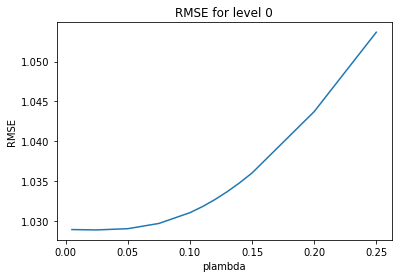

level: 1
Rating Number of level 1: 17935
Current plambda: 0.005
MF DONE
299698.138453
303313
Current RMSE: 0.994023176354
Current plambda: 0.025
MF DONE
298604.224123
303313
Current RMSE: 0.99220739888
Current plambda: 0.05
MF DONE
298001.834439
303313
Current RMSE: 0.99120607807
Current plambda: 0.075
MF DONE
298256.312373
303313
Current RMSE: 0.991629206754
Current plambda: 0.1
MF DONE
299443.431341
303313
Current RMSE: 0.993600686927
Current plambda: 0.11
MF DONE
300187.012478
303313
Current RMSE: 0.994833581951
Current plambda: 0.12
MF DONE
301082.822844
303313
Current RMSE: 0.996316854591
Current plambda: 0.13
MF DONE
302128.209999
303313
Current RMSE: 0.998045007531
Current plambda: 0.14
MF DONE
303319.773384
303313
Current RMSE: 1.0000111656
Current plambda: 0.15
MF DONE
304653.729666
303313
Current RMSE: 1.00220770513
Current plambda: 0.2
MF DONE
313197.9234
303313
Current RMSE: 1.0161642801
Current plambda: 0.25
MF DONE
322568.231113
303313
Current RMSE: 1.03125314028
min RMSE

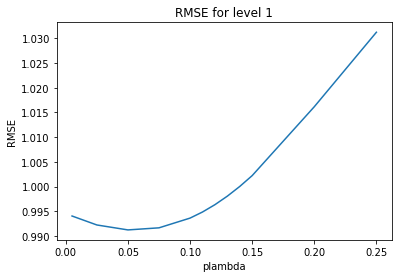

level: 2
Rating Number of level 2: 49545
Current plambda: 0.005
MF DONE
316545.591864
303292
Current RMSE: 1.02161593302
Current plambda: 0.025
MF DONE
303959.111614
303292
Current RMSE: 1.00109918029
Current plambda: 0.05
MF DONE
299736.944207
303292
Current RMSE: 0.994121943539
Current plambda: 0.075
MF DONE
298144.306572
303292
Current RMSE: 0.991477316603
Current plambda: 0.1
MF DONE
298520.382613
303292
Current RMSE: 0.992102438978
Current plambda: 0.11
MF DONE
299185.072182
303292
Current RMSE: 0.993206339263
Current plambda: 0.12
MF DONE
300127.77711
303292
Current RMSE: 0.994769859987
Current plambda: 0.13
MF DONE
301336.780888
303292
Current RMSE: 0.996771460397
Current plambda: 0.14
MF DONE
302797.196082
303292
Current RMSE: 0.99918394502
Current plambda: 0.15
MF DONE
304465.834967
303292
Current RMSE: 1.00193328769
Current plambda: 0.2
MF DONE
314589.703575
303292
Current RMSE: 1.01845483576
Current plambda: 0.25
MF DONE
325708.530592
303292
Current RMSE: 1.03629663787
min R

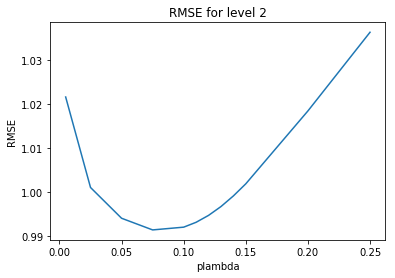

level: 3
Rating Number of level 3: 120632
Current plambda: 0.005
MF DONE
328754.087257
303235
Current RMSE: 1.04122818848
Current plambda: 0.025
MF DONE
307883.775046
303235
Current RMSE: 1.00763614556
Current plambda: 0.05
MF DONE
299368.971656
303235
Current RMSE: 0.993604910719
Current plambda: 0.075
MF DONE
295487.942547
303235
Current RMSE: 0.987143337161
Current plambda: 0.1
MF DONE
294716.915426
303235
Current RMSE: 0.985854601944
Current plambda: 0.11
MF DONE
295137.633044
303235
Current RMSE: 0.986558020141
Current plambda: 0.12
MF DONE
295922.617961
303235
Current RMSE: 0.987869135394
Current plambda: 0.13
MF DONE
297038.57161
303235
Current RMSE: 0.989730059035
Current plambda: 0.14
MF DONE
298454.648521
303235
Current RMSE: 0.992086432246
Current plambda: 0.15
MF DONE
300145.335065
303235
Current RMSE: 0.994892450665
Current plambda: 0.2
MF DONE
310709.176361
303235
Current RMSE: 1.01224904652
Current plambda: 0.25
MF DONE
321839.329015
303235
Current RMSE: 1.03021980271
mi

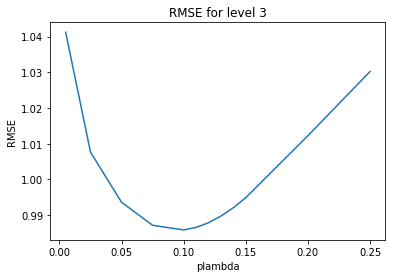

level: 4
Rating Number of level 4: 249223
Current plambda: 0.005
MF DONE
327216.027937
303204
Current RMSE: 1.03884276867
Current plambda: 0.025
MF DONE
307353.513754
303204
Current RMSE: 1.00681952247
Current plambda: 0.05
MF DONE
297961.371814
303204
Current RMSE: 0.991316921095
Current plambda: 0.075
MF DONE
293654.468214
303204
Current RMSE: 0.984126312152
Current plambda: 0.1
MF DONE
292900.833173
303204
Current RMSE: 0.982862669636
Current plambda: 0.11
MF DONE
293425.150236
303204
Current RMSE: 0.983741979618
Current plambda: 0.12
MF DONE
294359.218607
303204
Current RMSE: 0.985306521978
Current plambda: 0.13
MF DONE
295664.314944
303204
Current RMSE: 0.98748837609
Current plambda: 0.14
MF DONE
297314.319106
303204
Current RMSE: 0.990239964531
Current plambda: 0.15
MF DONE
299235.601591
303204
Current RMSE: 0.99343433976
Current plambda: 0.2
MF DONE
310307.497359
303204
Current RMSE: 1.01164623871
Current plambda: 0.25
MF DONE
321283.862559
303204
Current RMSE: 1.02938300301
min

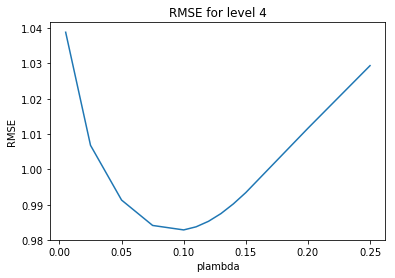

level: 5
Rating Number of level 5: 421584
Current plambda: 0.005
MF DONE
330039.060863
303180
Current RMSE: 1.04335570963
Current plambda: 0.025
MF DONE
310802.874809
303180
Current RMSE: 1.01249348946
Current plambda: 0.05
MF DONE
300838.907529
303180
Current RMSE: 0.996131622533
Current plambda: 0.075
MF DONE
296449.961107
303180
Current RMSE: 0.988838630691
Current plambda: 0.1
MF DONE
295767.731895
303180
Current RMSE: 0.987700153268
Current plambda: 0.11
MF DONE
296327.60013
303180
Current RMSE: 0.988634535961
Current plambda: 0.12
MF DONE
297299.99962
303180
Current RMSE: 0.990255310306
Current plambda: 0.13
MF DONE
298647.188345
303180
Current RMSE: 0.992496401646
Current plambda: 0.14
MF DONE
300291.44104
303180
Current RMSE: 0.995224829893
Current plambda: 0.15
MF DONE
302098.287852
303180
Current RMSE: 0.998214462151
Current plambda: 0.2
MF DONE
312495.634171
303180
Current RMSE: 1.01524697188
Current plambda: 0.25
MF DONE
322973.378073
303180
Current RMSE: 1.03212687999
min 

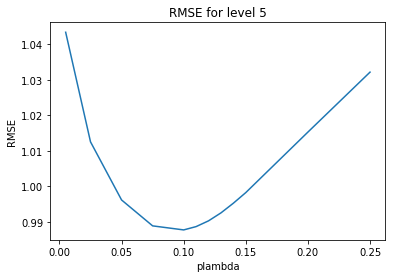

level: 6
Rating Number of level 6: 579197
Current plambda: 0.005
MF DONE
338231.980913
303141
Current RMSE: 1.05629444315
Current plambda: 0.025
MF DONE
318643.508808
303141
Current RMSE: 1.02525099257
Current plambda: 0.05
MF DONE
307886.486888
303141
Current RMSE: 1.00779679905
Current plambda: 0.075
MF DONE
303014.244661
303141
Current RMSE: 0.999790908204
Current plambda: 0.1
MF DONE
301586.40681
303141
Current RMSE: 0.997432562049
Current plambda: 0.11
MF DONE
301746.661209
303141
Current RMSE: 0.997697530436
Current plambda: 0.12
MF DONE
302271.8688
303141
Current RMSE: 0.998565428196
Current plambda: 0.13
MF DONE
303118.716463
303141
Current RMSE: 0.999963244914
Current plambda: 0.14
MF DONE
304238.785771
303141
Current RMSE: 1.00180904875
Current plambda: 0.15
MF DONE
305628.730179
303141
Current RMSE: 1.00409487189
Current plambda: 0.2
MF DONE
313926.354814
303141
Current RMSE: 1.01763386048
Current plambda: 0.25
MF DONE
322877.059029
303141
Current RMSE: 1.03203934608
min RMS

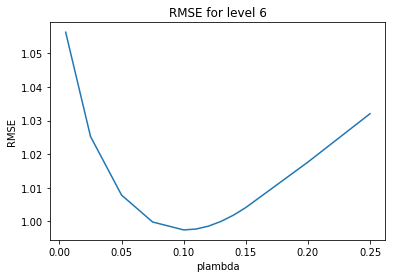

level: 7
Rating Number of level 7: 660707
Current plambda: 0.005
MF DONE
344618.353673
303121
Current RMSE: 1.06625526628
Current plambda: 0.025
MF DONE
327689.642788
303121
Current RMSE: 1.0397366312
Current plambda: 0.05
MF DONE
319360.345995
303121
Current RMSE: 1.0264374346
Current plambda: 0.075
MF DONE
315500.640717
303121
Current RMSE: 1.02021595301
Current plambda: 0.1
MF DONE
313982.640617
303121
Current RMSE: 1.01775865966
Current plambda: 0.11
MF DONE
313889.965158
303121
Current RMSE: 1.0176084472
Current plambda: 0.12
MF DONE
314057.721304
303121
Current RMSE: 1.01788033749
Current plambda: 0.13
MF DONE
314465.501608
303121
Current RMSE: 1.01854094361
Current plambda: 0.14
MF DONE
315069.016704
303121
Current RMSE: 1.01951785552
Current plambda: 0.15
MF DONE
315812.868909
303121
Current RMSE: 1.02072064519
Current plambda: 0.2
MF DONE
321213.968742
303121
Current RMSE: 1.02941193502
Current plambda: 0.25
MF DONE
327325.76791
303121
Current RMSE: 1.03915919591
min RMSE: 1.0

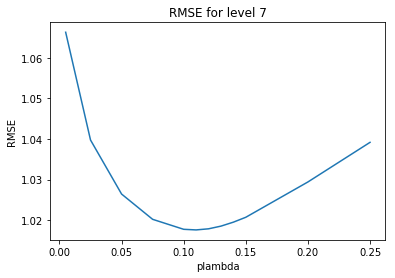

level: 8
Rating Number of level 8: 683000
Current plambda: 0.005
MF DONE
346715.343883
303109
Current RMSE: 1.06951557887
Current plambda: 0.025
MF DONE
332178.346001
303109
Current RMSE: 1.04685430484
Current plambda: 0.05
MF DONE
325639.814308
303109
Current RMSE: 1.0365000642
Current plambda: 0.075
MF DONE
322467.334456
303109
Current RMSE: 1.03143876102
Current plambda: 0.1
MF DONE
321053.282388
303109
Current RMSE: 1.02917479441
Current plambda: 0.11
MF DONE
320855.067243
303109
Current RMSE: 1.02885704415
Current plambda: 0.12
MF DONE
320833.158934
303109
Current RMSE: 1.02882191785
Current plambda: 0.13
MF DONE
320962.356246
303109
Current RMSE: 1.02902904676
Current plambda: 0.14
MF DONE
321214.314068
303109
Current RMSE: 1.02943286523
Current plambda: 0.15
MF DONE
321564.211636
303109
Current RMSE: 1.02999339134
Current plambda: 0.2
MF DONE
324314.41778
303109
Current RMSE: 1.03438856826
Current plambda: 0.25
MF DONE
327261.090208
303109
Current RMSE: 1.03907709265
min RMSE: 1

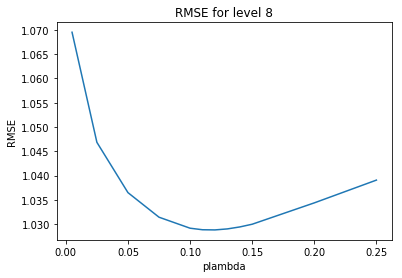

In [35]:
prediction_model = {}
rmst_dict = {"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[],"10":[]}
for level in range(depth_threshold + 1):
    level = str(level)
    print("level:", level)
    prediction_model.setdefault(level, {})
    train_lst = []       
    for pseudo_user_bound, userid in zip(lr_bound[level], range(len(lr_bound[level]))):
        if pseudo_user_bound[0] > pseudo_user_bound[1]:
            continue
        pseudo_user_lst = tree[pseudo_user_bound[0]:(pseudo_user_bound[1] + 1)]
        ratings_Pseudo_u2i = np.array(rating_matrix_csc_train[:, pseudo_user_lst].sum(axis=1))[:,0] / \
                                     (rating_matrix_csc_train[:, pseudo_user_lst].getnnz(axis=1)+1e-9)
        train_lst += [(userid, itemid, float(ratings_Pseudo_u2i[itemid])) \
                      for itemid in range(ratings_Pseudo_u2i.shape[0]) if ratings_Pseudo_u2i[itemid]]        

    print("Rating Number of level " + level + ": " + str(len(train_lst)))
    
    #### Train MF and Do validation ####
    min_RMSE = -1
    user_profile_list = []
    item_profile_list = []
    for plambda in lambda_list:
        print("Current plambda: " + str(plambda))
        MF.change_parameter(plambda)
        user_profile, item_profile = MF.matrix_factorization(train_lst)
        user_profile_list.append(user_profile)
        item_profile_list.append(item_profile)
        prediction_model[level]['upro'], prediction_model[level]['ipro'], prediction_model[level]['plambda'] \
                                         = user_profile, item_profile, plambda
        rmse = 0
        rmseNum = 0
        for userid in range(rating_matrix_csc_test.shape[1]):
    #         if userid % 100 == 0:
    #             print("%.2f%%" % (100 * userid / rating_matrix_csc_test.shape[1]))  
            pred_index = 0
            final_level = 0
            rated_item = []
            user_all_ratings = rating_matrix_csc_test[:,userid].nonzero()[0]
            for depth in range(int(level)):
                if split_item[depth][pred_index] not in user_all_ratings:
                    tmp_pred_index = 3*pred_index + 2
                    if tmp_pred_index in prediction_model[str(int(depth)+1)]['upro']:
                        final_level += 1
                        pred_index = tmp_pred_index
                    else:
                        break
                elif rating_matrix_csc_test[split_item[depth][pred_index], userid] > 3:
                    tmp_pred_index = 3*pred_index
                    if tmp_pred_index in prediction_model[str(int(depth)+1)]['upro']:
                        rated_item.append(split_item[depth][pred_index]-1)
                        final_level += 1
                        pred_index = tmp_pred_index
                    else:
                        break
                elif rating_matrix_csc_test[split_item[depth][pred_index], userid] <= 3:
                    tmp_pred_index = 3*pred_index + 1
                    if tmp_pred_index in prediction_model[str(int(depth)+1)]['upro']:
                        rated_item.append(split_item[depth][pred_index]-1)
                        final_level += 1
                        pred_index = tmp_pred_index
                    else:
                        break   
                        
            pred_rating = np.dot(np.array(prediction_model[str(final_level)]['upro'][pred_index]), \
                                 np.array(list(prediction_model[str(final_level)]['ipro'].values())).T) 
            real_rating = rating_matrix_csc_test[:, userid].toarray()
            non_zeros = list(np.nonzero(real_rating)[0])
            non_zeros = list(set(non_zeros).difference(set(rated_item)))
            non_zerosNum = pred_rating[non_zeros].shape[0]
            rmse += np.sum((pred_rating[non_zeros].T.reshape(non_zerosNum, 1)-real_rating[non_zeros])**2)
            rmseNum += len(non_zeros)
        RMSE = (rmse/rmseNum)**0.5
        print(rmse)
        print(rmseNum)
        print("Current RMSE: " + str(RMSE))
        rmst_dict[level].append(RMSE)
    min_MF = rmst_dict[level].index(min(rmst_dict[level]))   
    prediction_model[level]['upro'] = user_profile_list[min_MF]
    prediction_model[level]['ipro'] = item_profile_list[min_MF]
    prediction_model[level]['plambda'] = lambda_list[min_MF]
    print("min RMSE: " + str(min(rmst_dict[level])))
    plt.figure(1)
    plt.title('RMSE for level ' + level)
    plt.xlabel('plambda')
    plt.ylabel('RMSE')
    plt.plot(lambda_list, rmst_dict[level])
    plt.show()

In [36]:
MF.end()

SparkSession stopped.


In [65]:
import klepto
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)
Tree['prediction_model'] = prediction_model
Tree.dump()
Tree.clear()

In [40]:
rmst_dict

{'0': [1.0289273066540059,
  1.0288837895681573,
  1.0290381721427098,
  1.0296940990375782,
  1.031046861693139,
  1.0318020460273365,
  1.032680268663194,
  1.0336793353826721,
  1.0347959006350536,
  1.0360258243152738,
  1.0437239114387837,
  1.0536826006618596],
 '1': [0.99402317635368187,
  0.99220739888003262,
  0.99120607807034966,
  0.99162920675368593,
  0.99360068692665804,
  0.99483358195142402,
  0.99631685459104036,
  0.99804500753096048,
  1.00001116560404,
  1.0022077051270812,
  1.0161642801016224,
  1.0312531402840179],
 '10': [],
 '2': [1.0216159330179606,
  1.0010991802906022,
  0.99412194353850403,
  0.99147731660309035,
  0.99210243897793737,
  0.99320633926322666,
  0.99476985998688228,
  0.9967714603968445,
  0.99918394502024754,
  1.0019332876944895,
  1.0184548357574918,
  1.0362966378676646],
 '3': [1.0412281884757297,
  1.0076361455562224,
  0.99360491071932833,
  0.98714333716138336,
  0.98585460194422558,
  0.98655802014141258,
  0.98786913539397658,
  0.9

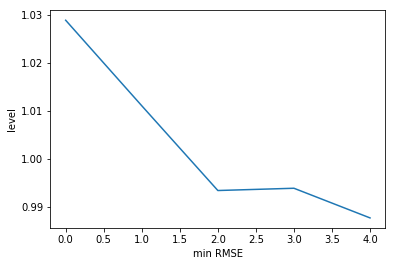

In [175]:
plt.figure(1)
plt.xlabel('min RMSE')
plt.ylabel('level')
plt.plot(list(range(5)), min_rmse_list)
plt.show()

In [64]:
import scipy.io as sio
for i in range(depth_threshold):
    sio.savemat('rmse_list' + str(i) + '.mat', {'rmse_list': rmst_dict[str(i)]})

In [ ]:
sio.savemat('min_rmse_list.mat', {'min_rmse_list':min_rmse_list})

In [60]:
nominator = 0
denominator = 0
level = '4'
for userid in range(rating_matrix_csc_test.shape[1]):
#         if userid % 100 == 0:
#             print("%.2f%%" % (100 * userid / rating_matrix_csc_test.shape[1]))  
    pred_index = 0
    final_level = 0
    rated_item = []
    user_all_ratings = rating_matrix_csc_test[:,userid].nonzero()[0]
    for depth in range(int(level)):
        if split_item[depth][pred_index] not in user_all_ratings:
            tmp_pred_index = 3*pred_index + 2
            if tmp_pred_index in prediction_model[str(int(depth)+1)]['upro']:
                final_level += 1
                pred_index = tmp_pred_index
            else:
                break
        elif rating_matrix_csc_test[split_item[depth][pred_index], userid] > 3:
            tmp_pred_index = 3*pred_index
            if tmp_pred_index in prediction_model[str(int(depth)+1)]['upro']:
                rated_item.append(split_item[depth][pred_index]-1)
                final_level += 1
                pred_index = tmp_pred_index
            else:
                break
        elif rating_matrix_csc_test[split_item[depth][pred_index], userid] <= 3:
            tmp_pred_index = 3*pred_index + 1
            if tmp_pred_index in prediction_model[str(int(depth)+1)]['upro']:
                rated_item.append(split_item[depth][pred_index]-1)
                final_level += 1
                pred_index = tmp_pred_index
            else:
                break   

    pred_rating = np.dot(np.array(prediction_model[str(final_level)]['upro'][pred_index]), \
                         np.array(list(prediction_model[str(final_level)]['ipro'].values())).T) 
    real_rating = rating_matrix_csc_test[:, userid].toarray()
    non_zeros = list(np.nonzero(real_rating)[0])
    non_zeros = list(set(non_zeros).difference(set(rated_item)))
    non_zerosNum = pred_rating[non_zeros].shape[0]
    pred_rating = pred_rating.reshape(pred_rating.shape[0], 1)
    nominator += np.multiply(pred_rating>3, real_rating>3).sum()
    denominator += (real_rating>3).sum()

In [61]:
precision = nominator/denominator

In [62]:
precision

0.89686567250347837